# Joint Line Fit

Create two data sets generated from a linear relation with the same slope but different constant offsets (intercepts).

Perform a chi-square fit to find the common slope and the two intercepts.

Then subclass the `LinFit` class in the [hyperfit](https://hyperfit.readthedocs.io/en/latest/) package to perform the same joint fit using `hyperfit`.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import minimize

from corner import corner

from hyperfit.linfit import LinFit

In [2]:
mpl.rc('font', size=14)

## Generate Data

Generate two independent data sets of two different sizes of the form

$$
\begin{align}
y_i^{(1)} &= ax_i^{(1)} + b^{(1)} \\
y_i^{(2)} &= ax_i^{(2)} + b^{(2)}
\end{align}
$$

I.e., the data share a slope but have different constants offsets. The data will also have separate covariances.

In [3]:
n, m = 15, 12

# Common slope but different intercepts.
a, b1, b2 = 2., 1., 2.

# Generate the first data set, and pack the results into the arrays data1 and cov1.
x1 = np.random.rand(n)
y1 = np.random.normal(a*x1 + b1, 0.2)
dx1, dy1, corrxy1 = (
    0.05 * np.random.rand(n) + 0.025,
    0.05 * np.random.rand(n) + 0.025,
    2.0 * (np.random.rand(n) - 0.5)
)
data1, cov1 = np.empty((2, n)), np.empty((2, 2, n))
for i, (x, y, ex, ey, rho_xy) in enumerate(zip(x1, y1, dx1, dy1, corrxy1)):
    cov1[:, :, i] = np.array([[ex ** 2, ex * ey * rho_xy], [ex * ey * rho_xy, ey ** 2]])
    data1[:, i] = np.random.multivariate_normal([x, y], cov1[:, :, i])

# Generate the second data set, and pack the results into the arrays data2 and cov2.
x2 = np.random.rand(m)
y2 = np.random.normal(a*x2 + b2, 0.2)
dx2, dy2, corrxy2 = (
    0.05 * np.random.rand(m) + 0.025,
    0.05 * np.random.rand(m) + 0.025,
    2.0 * (np.random.rand(m) - 0.5)
)
data2, cov2 = np.empty((2, m)), np.empty((2, 2, m))
for i, (x, y, ex, ey, rho_xy) in enumerate(zip(x2, y2, dx2, dy2, corrxy2)):
    cov2[:, :, i] = np.array([[ex ** 2, ex * ey * rho_xy], [ex * ey * rho_xy, ey ** 2]])
    data2[:, i] = np.random.multivariate_normal([x, y], cov2[:, :, i])

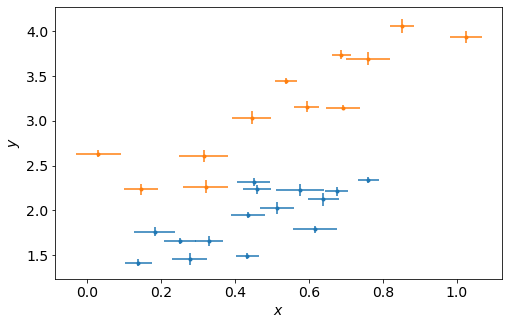

In [4]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
eb1 = ax.errorbar(data1[0], data1[1], xerr=np.sqrt(cov1[0,0]), yerr=np.sqrt(cov1[1,1]), fmt='.')
eb2 = ax.errorbar(data2[0], data2[1], xerr=np.sqrt(cov2[0,0]), yerr=np.sqrt(cov2[1,1]), fmt='.')
ax.set(xlabel='$x$', ylabel='$y$');

## Standard Fit

Attempt a standard $\chi^2$ fit to the data. Use both the uncertainties in $x$ and $y$, but ignore the covariances. Here we use the form of the $\chi^2$ defined in **Numerical Recipes in C++**, eq. 15.3.2:

$$
\chi^2(a,b) = \sum_{i}\frac{(y_i-ax_i-b)^2}{\sigma_{y_i}^2 + a^2\sigma_{x_i}^2}
$$

In this case, we divide the data in two and specify the parameters as the array `[a, b1, b2]`.

In [5]:
def chi2(params, data1, data2, cov1, cov2):
    """Chi-square function for joint slope fit to two data sets.
    
    Parameters
    ----------
    data1 : ndarray
        2xN array of [x1, y1] for data set 1.
    data2 : ndarray
        2xM array of [x2, y2] for data set 2.
    cov1 : ndarray
        2x2xN covariances for data set 1.
    cov2 : ndarray
        2x2xM covariances for data set 2.
        
    Returns
    -------
    chi2 : float
        Sum of chi-square fits to data sets 1 and 2.
    """
    a, b1, b2 = params
    
    x1, y1 = data1[0], data1[1]
    varx1, vary1 = cov1[0,0], cov1[1,1]
    chi2_1 = np.sum((y1 - a*x1 - b1)**2 / (vary1 + a**2*varx1))
    
    x2, y2 = data2[0], data2[1]
    varx2, vary2 = cov2[0,0], cov2[1,1]
    chi2_2 = np.sum((y2 - a*x2 - b2)**2 / (vary2 + a**2*varx2))
    
    return chi2_1 + chi2_2

### Peform the Fit and Plot Results

Use the `BFGS` minimizer to find the best fit parameters.

Note that the result may depend sensitively on the initial seed values.

In [6]:
p0 = [1.5, 0.7, 1.2]
res = minimize(chi2, p0, args=(data1, data2, cov1, cov2), method='BFGS')
res

      fun: 172.34441603069598
 hess_inv: array([[ 0.00613377, -0.00288969, -0.00356706],
       [-0.00288969,  0.00171709,  0.00167272],
       [-0.00356706,  0.00167272,  0.00257269]])
      jac: array([-3.81469727e-06,  0.00000000e+00,  1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 64
      nit: 13
     njev: 16
   status: 0
  success: True
        x: array([2.25047106, 0.86517594, 2.00384736])

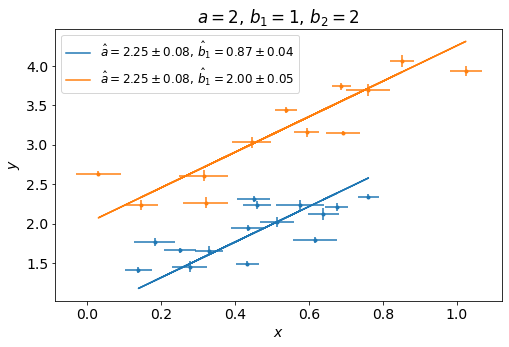

In [7]:
a_, b1_, b2_ = res.x
da_, db1_, db2_ = [np.sqrt(res.hess_inv[i,i]) for i in range(3)]

fig, ax = plt.subplots(1,1, figsize=(8,5))
eb1 = ax.errorbar(data1[0], data1[1], xerr=np.sqrt(cov1[0,0]), yerr=np.sqrt(cov1[1,1]), fmt='.')
ax.plot(data1[0], a_*data1[0] + b1_, color=eb1[0].get_color(),
        label=r'$\hat{{a}}={:.2f}\pm{:.2f}$, $\hat{{b}}_1={:.2f}\pm{:.2f}$'.format(a_, da_, b1_, db1_))

eb2 = ax.errorbar(data2[0], data2[1], xerr=np.sqrt(cov2[0,0]), yerr=np.sqrt(cov2[1,1]), fmt='.')
ax.plot(data2[0], a_*data2[0] + b2_, color=eb2[0].get_color(),
        label=r'$\hat{{a}}={:.2f}\pm{:.2f}$, $\hat{{b}}_1={:.2f}\pm{:.2f}$'.format(a_, da_, b2_, db2_))

ax.set(xlabel='$x$', ylabel='$y$',
       title='$a={:g}$, $b_1={:g}$, $b_2={:g}$'.format(a, b1, b2))
ax.legend(fontsize=12);